In [ ]:
# from scipy.sparse import csr_matrix

### Входные данные

#### Загрузка

In [ ]:
# !unzip capstone_user_identification.zip

In [7]:
# from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import pickle

In [8]:
# PATH_TO_DATA = '../capstone_user_identification'
PATH_TO_DATA = '../input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2'

times = ['time%s' % i for i in range(1, 11)]
sites = ['site%s' % i for i in range(1, 11)]
df_train = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id', parse_dates=times)
df_test = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id', parse_dates=times)
df_train.shape, df_test.shape

((253561, 21), (82797, 20))

In [9]:
df_train.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   site1   253561 non-null  int64         
 1   time1   253561 non-null  datetime64[ns]
 2   site2   250098 non-null  float64       
 3   time2   250098 non-null  datetime64[ns]
 4   site3   246919 non-null  float64       
 5   time3   246919 non-null  datetime64[ns]
 6   site4   244321 non-null  float64       
 7   time4   244321 non-null  datetime64[ns]
 8   site5   241829 non-null  float64       
 9   time5   241829 non-null  datetime64[ns]
 10  site6   239495 non-null  float64       
 11  time6   239495 non-null  datetime64[ns]
 12  site7   237297 non-null  float64       
 13  time7   237297 non-null  datetime64[ns]
 14  site8   235224 non-null  float64       
 15  time8   235224 non-null  datetime64[ns]
 16  site9   233084 non-null  float64       
 17  time9   233084 non-null  date

Словарь сайтов

In [11]:
with open(os.path.join(PATH_TO_DATA, 'site_dic.pkl'), 'rb') as f:
    site2id  = pickle.load(f)
id2site = {v:k for (k, v) in site2id.items()}
id2site[0] = 'unknown'

### Обработка

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler

import numpy as np

In [13]:
df_train.sort_values(by='time1', inplace=True)

In [14]:
class DataPreparator(BaseEstimator, TransformerMixin):
    """
    Fill NaN with zero values;
    No: Prepare a (Count)Vectorizer friendly 2D-list from data;
    No: Site ids to names.
    """
    def __init__(self, id2site):
        super().__init__()
        self.id2site = id2site
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        sites = ['site%s' % i for i in range(1, 11)]
        # Convert dataframe rows to strings
        return X[sites].fillna(0).astype('int')#.apply(lambda row: ' '.join([self.id2site[i] for i in row]), axis=1).tolist()

In [15]:
class ListPreparator(BaseEstimator, TransformerMixin):
    """
    Prepare a CountVectorizer friendly 2D-list from data.
    """
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.values.tolist()
        # Convert dataframe rows to strings
        return [" ".join([str(site) for site in row]) for row in X]

In [16]:
vectorizer_pipeline = Pipeline([
    ("preparator", DataPreparator(id2site)),
    ("list_preparator", ListPreparator()),
    ("vectorizer", CountVectorizer(ngram_range=(1, 2), max_features=20000))  # tokenizer=lambda s: s.split()
#     ("vectorizer", TfidfVectorizer(ngram_range=(1, 3)))
])

In [67]:
%%time
X_train_vectorized = vectorizer_pipeline.fit_transform(df_train)
X_train_vectorized

CPU times: user 9.3 s, sys: 193 ms, total: 9.5 s
Wall time: 9.5 s


<253561x20000 sparse matrix of type '<class 'numpy.int64'>'
	with 2498250 stored elements in Compressed Sparse Row format>

In [18]:
y_train = df_train["target"].astype('int').values

Опции:
- CountVectorizer ngram_range max_features
    - (1, 1)
        - max-k: 0.8530563468012738, 0.08925871896536618
    - (1, 2)
        - max-k: 0.8577666221636842, 0.09371826647019514
        - 50000: 0.858414628277273, 0.09308624515067462
        - 20000: 0.8600043484189314, 0.0901820258132247
    - (1, 3)
        - max-k: 0.8560039171386127, 0.09631952839070929
- TfidfVectorizer ngram_range max_features
    - (1, 1)
        - max-k: 0.8391530980059445, 0.08120401396593267
    - (1, 2)
        - max-k: 0.8294502665752119, 0.08421253009084147
    - (1, 3)
        - max-k: 0.8230380243367905, 0.08660127058036823

Выбираем CountVectorizer(ngram_range=(1, 2), max_features=20000)

### Feature engineering

In [19]:
from scipy.sparse import hstack
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

In [20]:
feature_names = ['morning', 'day', 'evening', 'weekday', 'year', 'session_duration']
# + list(calendar.day_name)

Рассмотрим признаки:
- Дата
    - час начала сессии
        - утро
        - день
        - вечер
        - ночь
        - циклические координаты (sin|cos часа)
    - месяц
        - сезон
    - год
        - год + месяц
    - день
        - выходной / будний
        - dummies
        - is_monday...
    - длина сессии
        - длина посещений каждого сайта
- Сайт
    - число уникальных сайтов в сессии (сколько повторов за сессию)
    - факт посещения абсолютно уникальных сайтов
    - факт посещения сайтов из топ-10 популярных сайтов
    - посещение определённых сайтов (facebook итд)

In [21]:
time_features = pd.DataFrame()
df_train_times = df_train[times]

In [22]:
def feature_hist(feature, df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    if df[feature].dtype in ['int', 'bool']:
        sns.countplot(df[feature], ax=ax1)
        sns.countplot(df[y_train == 1][feature], ax=ax2)
    elif df[feature].dtype == 'float':
        sns.histplot(df[feature], ax=ax1)
        sns.histplot(df[y_train == 1][feature], ax=ax2)
    ax1.set_title('All')
    ax2.set_title('Target');

#### Час

In [23]:
time_features['hour'] = df_train_times['time1'].apply(lambda ts: ts.hour)

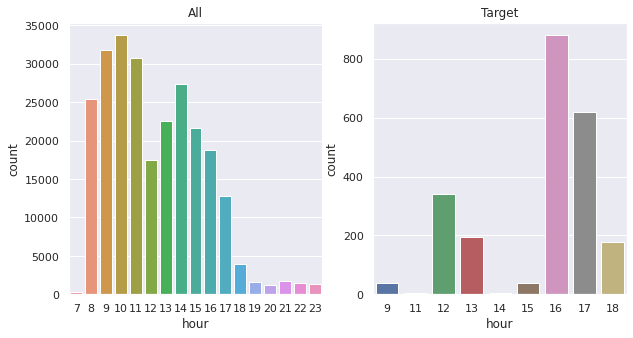

In [24]:
feature_hist('hour', time_features)

In [124]:
hour = time_features['hour']

In [240]:
morning = (hour >= 7) & (hour <= 11)
midday = (hour >= 12) & (hour <= 18)
evening = (hour >= 19) & (hour <= 23)

In [241]:
time_features['morning'] = morning.astype('int')
time_features['midday'] = midday.astype('int')
time_features['evening'] = evening.astype('int')
time_features

,hour,month,year,day,duration,morning,midday,evening,weekend
session_id,,,,,,,,,
21669,8,1,2013,5,0.0,1,0,0,1
54843,8,1,2013,5,1786.0,1,0,0,1
77292,8,1,2013,5,4.0,1,0,0,1
114021,8,1,2013,5,3.0,1,0,0,1
146670,8,1,2013,5,2.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...
12224,23,4,2014,2,12.0,0,0,1,0
164438,23,4,2014,2,178.0,0,0,1,0
12221,23,4,2014,2,28.0,0,0,1,0


#### Месяц

In [25]:
time_features['month'] = df_train_times['time1'].apply(lambda ts: ts.month)

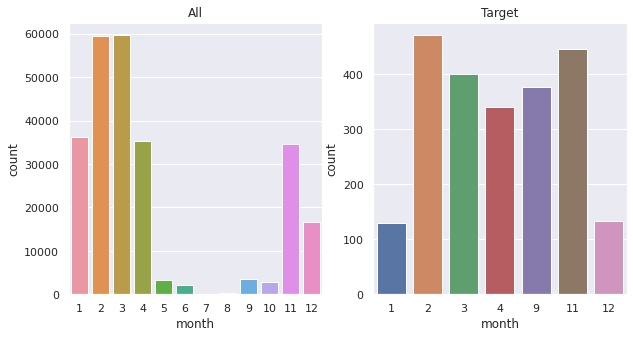

In [26]:
feature_hist('month', time_features)

#### Год

In [27]:
time_features['year'] = df_train_times['time1'].apply(lambda ts: ts.year)

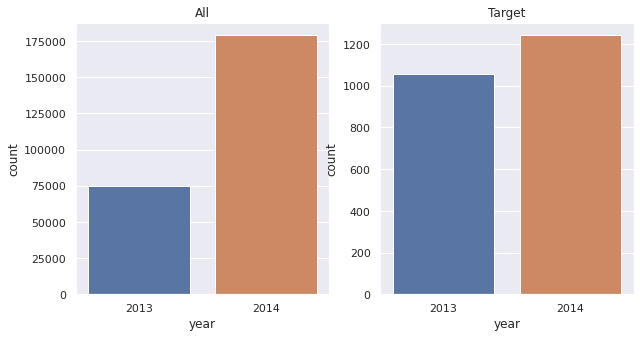

In [28]:
feature_hist('year', time_features)

#### День недели

In [29]:
time_features['day'] = df_train_times['time1'].apply(lambda ts: ts.weekday())

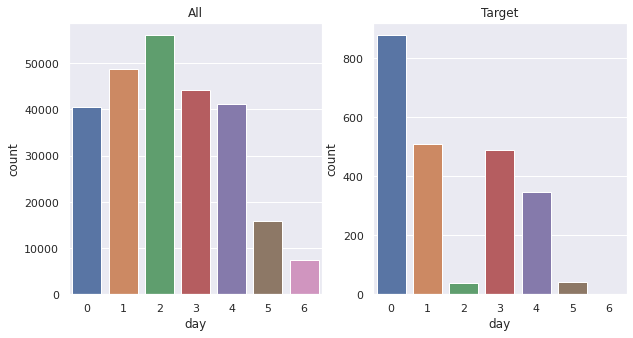

In [30]:
feature_hist('day', time_features)

In [230]:
time_features['weekend'] = time_features['day'].apply(lambda day: day in [5, 6]).astype('int')

#### Длина сессии

In [31]:
time_features['duration'] = df_train_times.apply(lambda row: \
                                                 (row.max() - row.min()).total_seconds(), axis=1)

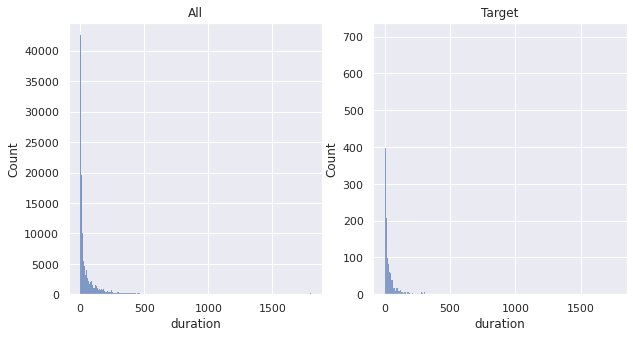

In [32]:
feature_hist('duration', time_features)

#### Топ-10 сайтов

In [33]:
df_train_sites = df_train[sites]
df_train_sites = df_train_sites.fillna(0).astype(int)

In [34]:
site_counts = {}
for session in df_train_sites.values:
    for site in session:
        if site in site_counts:
            site_counts[site] += 1
        else:
            site_counts[site] = 1
site_counts.pop(0)
top10 = [k for k, _ in sorted(site_counts.items(), key=lambda item: item[1], reverse=True)][:10]
top10

[21, 23, 782, 22, 29, 167, 780, 778, 52, 812]

In [35]:
for site_id in top10:
    print(id2site[site_id])

www.google.fr
www.google.com
annotathon.org
apis.google.com
www.facebook.com
www.bing.com
blast.ncbi.nlm.nih.gov
www.ncbi.nlm.nih.gov
clients1.google.com
mail.google.com


In [74]:
%%time
site_features = pd.DataFrame()
site_features['has_top10'] = df_train_sites.apply(lambda session: session.isin(top10).any().astype('int'), axis=1)

CPU times: user 49.2 s, sys: 57.1 ms, total: 49.3 s
Wall time: 49.2 s


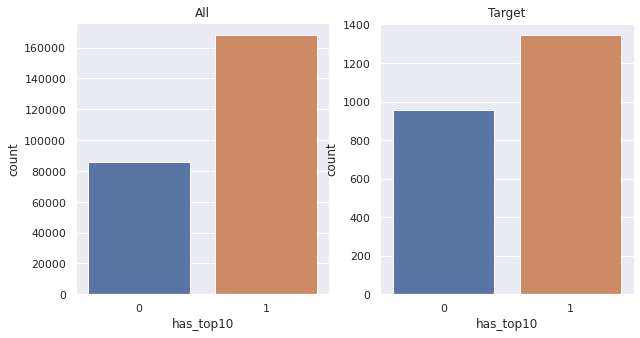

In [75]:
feature_hist('has_top10', site_features)

#### Число уникальных сайтов

In [220]:
site_features['n_unique'] = df_train[sites].apply(lambda session: session.nunique(), axis=1)

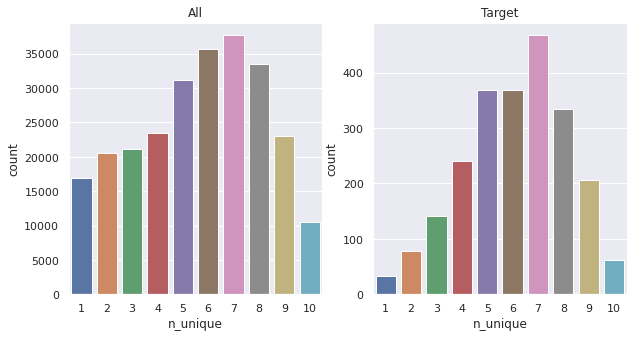

In [221]:
feature_hist('n_unique', site_features)

#### Абсолютно уникальные сайты

In [52]:
absolutely_unique_sites.update(df_train_sites.iloc[0])

In [75]:
a = set()
b = set(df_train_sites.iloc[0])
a, b

(set(), {0, 55, 56})

In [79]:
b = set(df_train_sites.iloc[2])
b

{784, 945, 946, 948, 949, 951}

In [80]:
a.symmetric_difference_update(b)
a

{784, 945, 946, 948, 949, 951}

In [74]:
a.update(b)
a

{0, 55, 56}

In [62]:
a.difference_update(a)

In [40]:
absolutely_unique_sites, full_sites = set()
for session in df_train_sites.values:
    uniques = set(session)
    uniques.difference_update(full_sites)
    absolutely_unique_sites.update(uniques)

ValueError: not enough values to unpack (expected 2, got 0)

In [88]:
len(absolutely_unique_sites)

27749

In [93]:
absolutely_unique_sites

{24,
 94,
 95,
 97,
 98,
 100,
 101,
 112,
 114,
 165,
 184,
 228,
 309,
 311,
 353,
 70,
 354,
 14,
 368,
 365,
 372,
 369,
 371,
 375,
 376,
 377,
 378,
 379,
 380,
 381,
 382,
 398,
 405,
 406,
 407,
 409,
 410,
 412,
 413,
 414,
 416,
 418,
 419,
 420,
 421,
 422,
 423,
 424,
 426,
 427,
 13110,
 437,
 449,
 452,
 463,
 475,
 472,
 471,
 473,
 479,
 484,
 485,
 488,
 491,
 483,
 13122,
 495,
 494,
 498,
 520,
 523,
 524,
 526,
 529,
 531,
 580,
 575,
 582,
 584,
 595,
 120,
 610,
 611,
 615,
 620,
 626,
 627,
 628,
 635,
 634,
 641,
 642,
 645,
 649,
 650,
 680,
 700,
 711,
 713,
 730,
 736,
 26197,
 733,
 737,
 739,
 742,
 6779,
 755,
 26202,
 787,
 797,
 798,
 801,
 802,
 804,
 807,
 809,
 822,
 825,
 826,
 838,
 839,
 842,
 837,
 846,
 848,
 858,
 852,
 170,
 859,
 874,
 877,
 886,
 892,
 2612,
 895,
 894,
 528,
 897,
 904,
 180,
 908,
 915,
 916,
 921,
 924,
 928,
 931,
 932,
 938,
 941,
 957,
 193,
 983,
 978,
 5249,
 992,
 984,
 995,
 988,
 996,
 1005,
 1010,
 1002,
 1013,
 1

In [97]:
site_counts[13122]

285

In [98]:
id2site[13122]

'www.mangahere.com'

In [46]:
set_of_sites = set()
for session in df_train_sites.values:
    set_of_sites.update(session)
len(set_of_sites)

41602

In [48]:
set_of_sites_target = set()
for session in df_train_sites[y_train == 1].values:
    set_of_sites_target.update(session)
len(set_of_sites_target)

1054

In [49]:
len(set_of_sites_target.intersection(set_of_sites))

1054

TBD

===============================

In [ ]:
# class AttributesAdder(BaseEstimator, TransformerMixin):
#     """
#     Add new attributes to training and test set.
#     """ 
#     def fit(self, X, y=None):
#         return self 
    
#     def transform(self, X, y=None):
#         # intraday features
#         hour = X['time1'].apply(lambda ts: ts.hour)#.values
#         morning = ((hour >= 7) & (hour <= 11)).astype('int')#.reshape(-1, 1)
#         day = ((hour >= 12) & (hour <= 18)).astype('int')
#         evening = ((hour >= 19) & (hour <= 23)).astype('int')
#         night = ((hour >= 0) & (hour <= 6)).astype('int')
        
#         # season features
#         month = X['time1'].apply(lambda ts: ts.month)
#         summer = ((month >= 6) & (month <= 8)).astype('int')
        
#         # day of the week features
#         weekday = X['time1'].apply(lambda ts: ts.weekday()).astype('int')
#         #     is_monday = np.isin(weekday, [0])
#         #     is_wednesday = np.isin(weekday, [2])
#         #     is_sunday = np.isin(weekday, [6])
#         #     is_weekend = np.isin(weekday, [0, 2, 6])
#         #     weekdays = pd.get_dummies(weekday.flatten()).to_numpy().reshape(7, -1, 1)
        
#         # year features
# #         year = X['time1'].apply(lambda ts: ts.year).astype('int') / 1e3
#         year_month = X['time1'].apply(lambda t: 100 * t.year + t.month) / 1e5
        
#         X = np.c_[morning.values, day.values, evening.values, weekday.values, year_month.values]

#         return X

In [ ]:
# class ScaledAttributesAdder(BaseEstimator, TransformerMixin):
#     """
#     Add new features, that should be scaled.
#     """
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X, y=None):
#         # session time features
#         times = ['time%s' % i for i in range(1, 11)]
#         sites = ['site%s' % i for i in range(1, 11)]
        
#         # session duration: take to the power of 1/5 to normalize the distribution
#         session_duration = (X[times].max(axis=1) - X[times].min(axis=1)).astype('timedelta64[ms]').astype(int) #** 0.2
        
#         # number of sites visited in a session
#         number_of_sites = X[times].isnull().sum(axis=1).apply(lambda x: 10 - x)
        
#         # average time spent on one site during a session
#         time_per_site = (session_duration / number_of_sites) #** 0.2
        
# #         unique_sites = X[sites].apply(lambda sites: sites.nunique(), axis=1)
        
#         X = np.c_[session_duration.values]
#         return X

In [ ]:
# attributes_pipeline = Pipeline([
#     ("adder", AttributesAdder())
# ])

# scaled_attributes_pipeline = Pipeline([
#     ("adder", ScaledAttributesAdder()),
#     ("scaler", StandardScaler())
# ])

# feature_pipeline = FeatureUnion(transformer_list=[
#     ('attributes_pipeline', attributes_pipeline),
#     ('scaled_attributes_pipeline', scaled_attributes_pipeline)
# ])

In [ ]:
# %%time
# X_train_features = feature_pipeline.fit_transform(df_train)

In [ ]:
# X_train = hstack([X_train_vectorized, X_train_features])
# X_train

=========================================

#### Feature selection

In [95]:
from sklearn.preprocessing import StandardScaler

In [242]:
X_train_features = pd.concat([time_features, site_features], axis=1)
X_train_features

,hour,month,year,day,duration,morning,midday,evening,weekend,has_top10,n_unique
session_id,,,,,,,,,,,
21669,8,1,2013,5,0.0,1,0,0,1,0,2
54843,8,1,2013,5,1786.0,1,0,0,1,0,2
77292,8,1,2013,5,4.0,1,0,0,1,0,6
114021,8,1,2013,5,3.0,1,0,0,1,0,5
146670,8,1,2013,5,2.0,1,0,0,1,0,6
...,...,...,...,...,...,...,...,...,...,...,...
12224,23,4,2014,2,12.0,0,0,1,0,1,6
164438,23,4,2014,2,178.0,0,0,1,0,1,7
12221,23,4,2014,2,28.0,0,0,1,0,1,8


In [243]:
X_train_features_scaled = pd.DataFrame(StandardScaler().fit_transform(X_train_features), columns=X_train_features.columns)
X_train_features_scaled

,hour,month,year,day,duration,morning,midday,evening,weekend,has_top10,n_unique
0,-1.357366,-0.943567,-1.547749,1.682905,-0.468233,1.039061,-0.98128,-0.171577,3.156257,-1.400389,-1.457582
1,-1.357366,-0.943567,-1.547749,1.682905,5.570015,1.039061,-0.98128,-0.171577,3.156257,-1.400389,-1.457582
2,-1.357366,-0.943567,-1.547749,1.682905,-0.454709,1.039061,-0.98128,-0.171577,3.156257,-1.400389,0.144865
3,-1.357366,-0.943567,-1.547749,1.682905,-0.458090,1.039061,-0.98128,-0.171577,3.156257,-1.400389,-0.255747
4,-1.357366,-0.943567,-1.547749,1.682905,-0.461471,1.039061,-0.98128,-0.171577,3.156257,-1.400389,0.144865
...,...,...,...,...,...,...,...,...,...,...,...
253556,3.390349,-0.137395,0.646100,-0.179911,-0.427662,-0.962408,-0.98128,5.828302,-0.316831,0.714087,0.144865
253557,3.390349,-0.137395,0.646100,-0.179911,0.133564,-0.962408,-0.98128,5.828302,-0.316831,0.714087,0.545477
253558,3.390349,-0.137395,0.646100,-0.179911,-0.373568,-0.962408,-0.98128,5.828302,-0.316831,0.714087,0.946088
253559,3.390349,-0.137395,0.646100,-0.179911,-0.207905,-0.962408,-0.98128,5.828302,-0.316831,-1.400389,0.545477


In [244]:
X_train = hstack([X_train_vectorized, pd.DataFrame(X_train_features_scaled[['morning', 'evening', 'midday']])])
X_train

<253561x20003 sparse matrix of type '<class 'numpy.float64'>'
	with 3258933 stored elements in COOrdinate format>

In [ ]:
# pd.DataFrame(X_train_features, columns=feature_names)

### Модель

In [77]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

#### Обучение и подбор гиперпараметров

In [78]:
model = SGDClassifier(loss='log', random_state=2179, n_jobs=-1)
time_split = TimeSeriesSplit(n_splits=10)

In [ ]:
# grid = {
#     'penalty': ['l2'],
#     'alpha': np.linspace(3e-05, 5e-05, 11)
# }

In [ ]:
# %%time

# search = GridSearchCV(model, param_grid=grid, cv=time_split, scoring='roc_auc')
# search.fit(X_train, y_train)

In [ ]:
# search.best_params_, search.best_score_

=======================================================

In [245]:
%%time

# sites = ['site%s' % i for i in range(1, 11)]

cv_scores = cross_val_score(model, X_train, y_train, cv=time_split, scoring='roc_auc', n_jobs=-1)

CPU times: user 195 ms, sys: 147 ms, total: 342 ms
Wall time: 3.84 s


In [246]:
cv_scores, cv_scores.mean(), cv_scores.std()

(array([0.89775759, 0.78055712, 0.92448428, 0.96761973, 0.90301772,
        0.9479116 , 0.94514178, 0.92667816, 0.9536884 , 0.94456394]),
 0.9191420326909544,
 0.050697025386069315)

0.9197500019625826

0.9315069358401142,
 0.044345068769381366 0 2 6

0.9180564468510812,
 0.05889198351691508 baseline

0.9232962337585114,
 0.058257317090901546

0.9287111177172779,
 0.04434090003756869 2

### Тест

In [247]:
import eli5
import calendar

def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                               
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [ ]:
%%time
X_test_vectorized = vectorizer_pipeline.transform(df_test)
X_test_features = feature_pipeline.transform(df_test)
X_test = hstack([X_test_vectorized, X_test_features])

X_test

In [ ]:
search.best_estimator_.fit(X_train, y_train)
logit_test_pred_proba = search.best_estimator_.predict_proba(X_test)

In [ ]:
# pd.DataFrame({'feature': feature_names, 'coef': search.best_estimator_.coef_.flatten()[-len(feature_names):]})

In [ ]:
eli5.show_weights(estimator=search.best_estimator_, feature_names=vectorizer_pipeline['vectorizer'].get_feature_names() \
                  + feature_names, top=30)

In [ ]:
write_to_submission_file(logit_test_pred_proba[:, 1], 'result.csv')